# Analysis of relationship between ELO and Variance

## Read in packages, graph, and functions

In [2]:
from collections import defaultdict
import sys
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import chess
import subprocess
import timeit
import pickle
import stockfish
from stockfish import Stockfish
import chess
import chess.engine
import warnings
warnings.filterwarnings('ignore')

engine = chess.engine.SimpleEngine.popen_uci("../stockfish-10-64")
stockfish = Stockfish("../stockfish-10-64")

In [4]:
g = nx.read_gpickle('../graph-pickle/690k_30.gpickle')

In [5]:
def varWeighted(scores, counts):
    if (len(counts)<2):
        return None
    else:
        weightedMean = sum([a*b for a,b in zip(scores,counts)])/sum(counts)
        scoreDiffs = [(score - weightedMean)**2 for score in scores]
        V1 = sum(counts)
        V2 = sum([count**2 for count in counts])
        var = (V1/(V1**2-V2)) * sum([a*b for a,b in zip(counts,scoreDiffs)])
        return var
    
def get_score(san):
    board = chess.Board()
    for move in san:
        try:
            board.push_san(move)
        except:
            break
    currFen = board.fen()
    score = engine.analyse(board, chess.engine.Limit(time=.05), info=chess.engine.INFO_SCORE)
    if('#' in str(score['score'])):
        if('-' in str(score['score'])):
            return -39765
        else:
            return 39765
    else:
        score = int(str(score["score"]))
    return score

def san_to_fen(san):
    board = chess.Board()
    for move in san:
        try:
            board.push_san(move)
        except:
            break
    currFen = board.fen()
    return currFen

def get_node_sd(node):
    scores = []
    counts = []
    try:
        for neighbor in list(g.neighbors(node)):
            scores.append(nx.get_node_attributes(g, 'score')[neighbor])
            counts.append(nx.get_node_attributes(g, 'movelistCount')[neighbor][node])
        return node, np.sqrt(varWeighted(scores,counts))
    except:
        return node, None

## Function to get score and Variance 
for each move in san, then split by black and white

In [6]:
def get_sd_score_from_san(san):
    board = chess.Board()
    sd_list = []
    score_list = []
    for move in san:
        try:
            board.push_san(move)
            currFen = board.fen()
            board = chess.Board(currFen)
            sf = engine.analyse(board, chess.engine.Limit(time=0.05))
            
            if('#' in str(sf['score'])):
                if('-' in str(sf['score'])):
                    sf =  -39765
                else:
                    sf =  39765
            else:
                sf = int(str(sf["score"]))*-1
            score_list.append(sf)
            scores = []
            counts = []
            for neighbor in list(g.neighbors(currFen)):
                scores.append(nx.get_node_attributes(g, 'score')[neighbor])
                counts.append(nx.get_node_attributes(g, 'count')[neighbor])

            sd_list.append(np.sqrt(varWeighted(scores, counts)))
        except:
            break
    return pd.Series([sd_list[::2],sd_list[1::2], score_list[::2],score_list[1::2]]) 
        ##white, black sd, white, black score
#     return(sd_list, score_list)

### Read in pickled df

In [7]:
df_test = pd.read_pickle("./DF_sd_sf_2000.pkl")

#### Calculate max SD and ELO difference

In [14]:
df_test['max_white_sd'] = df_test.sd_white.apply(lambda x: 0 if len(x) == 0 else max(x))
df_test['max_black_sd'] = df_test.sd_black.apply(lambda x: 0 if len(x) == 0 else max(x))
df_test['mean_white_sd'] = df_test.sd_white.apply(lambda x: 0 if len(x) == 0 else np.mean(x))
df_test['mean_black_sd'] = df_test.sd_black.apply(lambda x: 0 if len(x) == 0 else np.mean(x))
df_test['max_white_score'] = df_test.score_white.apply(lambda x: 0 if len(x) == 0 else max(x))
df_test.head(2)

,Event,Site,White,Black,Result,UTCDate,UTCTime,WhiteElo,BlackElo,WhiteRatingDiff,...,sd_white,sd_black,score_white,score_black,max_white_sd,max_black_sd,elo_diff,mean_white_sd,mean_black_sd,max_white_score
0,Rated Classical game,https://lichess.org/j1dkb5dw,BFG9k,mamalak,1-0,2012.12.31,23:01:03,1639,1403.0,+5,...,"[36.54898214746768, 51.68424175964618]","[69.49150941681832, 57.91136991521607]","[13, 14, 55]","[-62, -139]",51.684242,69.491509,236.0,44.116612,63.701440,55
1,Rated Classical game,https://lichess.org/a9tcp02g,Desmond_Wilson,savinka59,1-0,2012.12.31,23:04:12,1654,1919.0,+19,...,"[42.700943259251886, 40.713433829788556, 25.43...","[39.71234421228449, 25.62968487845111, 30.1709...","[1, 17, 1, -26]","[-58, -62, -58]",42.700943,39.712344,-265.0,36.284541,31.837663,17


In [15]:
df_test['WhiteElo'] = df_test['WhiteElo'].apply(pd.to_numeric)
df_test['BlackElo'] = df_test['BlackElo'].apply(pd.to_numeric, errors= 'coerce')
df_test['elo_diff'] = df_test['WhiteElo'] - df_test['BlackElo']

### Sanity check: Plot relationship between ELO diff and SF score (move quality)

CORR: 0.13341842340324586


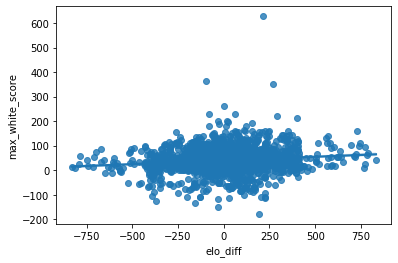

In [21]:
%matplotlib inline
import seaborn as sns
print("CORR:",df_test['elo_diff'].corr(df_test['max_white_score']))
ax = sns.regplot('elo_diff' , 'max_white_score', data = df_test)
#plt.ylim(0,400)

### Plot relationships between ELO difference and mean/max SD

CORR: -0.001037675751053465


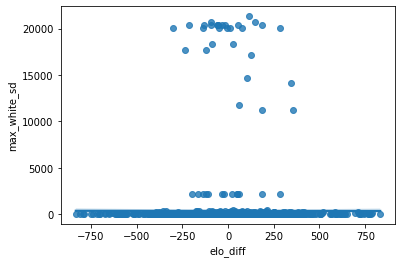

In [10]:
%matplotlib inline
import seaborn as sns
print("CORR:",df_test['elo_diff'].corr(df_test['max_white_sd']))
ax = sns.regplot('elo_diff' , 'max_white_sd', data = df_test)
#plt.ylim(0,400)

CORR: 0.08747288519039176


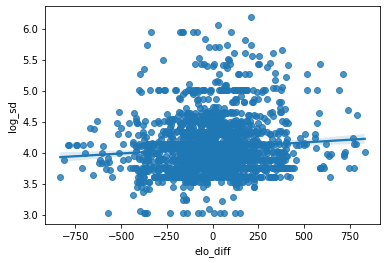

In [11]:
df_test2 = df_test[df_test['max_white_sd'] <500]
df_test2['log_sd'] = df_test2.max_white_sd.apply(lambda x: np.log(x))
print("CORR:",df_test2['elo_diff'].corr(df_test2['log_sd']))
ax = sns.regplot('elo_diff' , 'log_sd', data = df_test2)

CORR: -0.002479336665048891


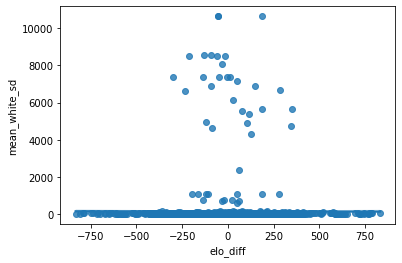

In [12]:
%matplotlib inline
import seaborn as sns
print("CORR:",df_test['elo_diff'].corr(df_test['mean_white_sd']))
ax = sns.regplot('elo_diff' , 'mean_white_sd', data = df_test)
#plt.ylim(0,400)

CORR: 0.05925209604447583


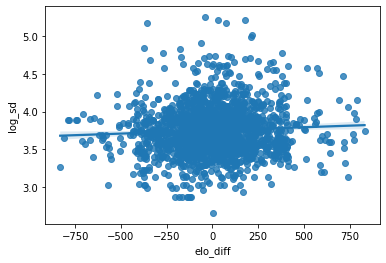

In [13]:
df_test2 = df_test[df_test['mean_white_sd'] <500]
df_test2['log_sd'] = df_test2.mean_white_sd.apply(lambda x: np.log(x))
print("CORR:",df_test2['elo_diff'].corr(df_test2['log_sd']))
ax = sns.regplot('elo_diff' , 'log_sd', data = df_test2)

### How does stockfish eval correlate with riskiness?
Make a list of each move's riskiness, and get corresponding stockfish eval.

In [13]:
#remove any lists without risk evals
df_short = df_test[df_test['sd_white'].apply(lambda x: len(x)>1)]

In [14]:
#trim sf lists until they match length of sd
def match_length(l1,l2):
    if(len(l2)>len(l1)):
        while len(l2)>len(l1):
            l2.pop()
    return(l2)
    
df_short['white_short'] = df_short.apply(lambda x: match_length(x['sd_white'], x['score_white']), axis =1)

In [15]:
score = []
for s in df_short['white_short']:
    for i in s:
        score.append(i)
        
print(len(score))

sd = []
for s in df_short['sd_white']:
    for i in s:
        sd.append(i)
        
print(len(sd))

6319
6319


-0.10738623350946588


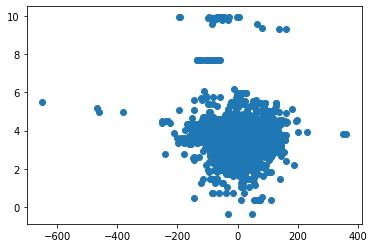

In [16]:
from scipy.stats.stats import pearsonr
print(pearsonr(score,sd)[0])
plt.scatter(score,np.log(sd))

### How does opponent's previous move quality affect riskiness?
Get list of black riskiness as long as white sd

then plot black riskiness off white score

In [17]:
df_short['white_prev'] = df_short.apply(lambda x: match_length(x['sd_black'], x['score_white']), axis =1)

In [18]:
score = []
for s in df_short['white_prev']:
    for i in s:
        score.append(i)
        
print(len(score))

sd = []
for s in df_short['sd_black']:
    for i in s:
        sd.append(i)
        
print(len(sd))


5318
5318


In [ ]:
print(pearsonr(score,sd)[0])
plt.scatter(score,np.log(sd))